Preprocessing

In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords and apply lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data['processed_text'] = data['medical_abstract'].apply(preprocess_text)
    return data

data = load_and_preprocess_data('data.csv')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ziko1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ziko1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Splitting the Data

In [4]:
from sklearn.model_selection import train_test_split

train_val, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val, test_size=0.25, random_state=42)

Feature Engineering for Traditional Models:
SVMs, logistic regression, etc.



In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = vectorizer.transform(test_data['processed_text']).toarray()

y_train = train_data['condition_label']
y_val = val_data['condition_label']
y_test = test_data['condition_label']

 Preparing for BERT and Other Transformers

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_for_bert(data):
    texts = data['processed_text'].tolist()
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_for_bert(train_data)
val_encodings = tokenize_for_bert(val_data)
test_encodings = tokenize_for_bert(test_data)


c:\Users\ziko1\.conda\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ziko1\.conda\envs\pytorch-env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Function to Plot Learning Curves:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



*Model Training:*

In [ ]:
#SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the model and parameter grid
svc = SVC()
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Setup GridSearchCV
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')

# Fit the model
grid_search_svc.fit(X_train_tfidf, y_train)

# Evaluate the model
best_svc = grid_search_svc.best_estimator_
print(f"Best Parameters for SVM: {grid_search_svc.best_params_}")


### Decision Tree


Training a Decision Tree model using the default hyperparameters and evaluate its.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree model with default hyperparameters
dt_classifier = DecisionTreeClassifier()

# Train the Decision Tree model
dt_classifier.fit(X_train_tfidf, y_train)

# Predict on the test data
y_test_pred = dt_classifier.predict(X_test_tfidf)
# Predict on the validation data
y_val_pred = dt_classifier.predict(X_val_tfidf)

# Evaluate the model on the test data for accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy on Test Data:", test_accuracy)

# Evaluate the model on the validation data for accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy on Validation Data:", val_accuracy)


Accuracy on Test Data: 0.45064935064935063
Accuracy on Validation Data: 0.45670995670995673


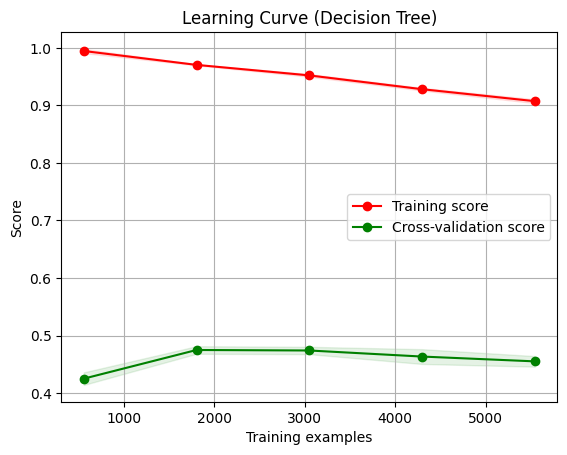

In [8]:
dt_classifier = DecisionTreeClassifier() 
plot_learning_curve(dt_classifier, "Learning Curve (Decision Tree)", X_train_tfidf, y_train, cv=5)
plt.show()

#### Hyperparameter tuning

Useing the GridSearchCV module of the sklearn library to tune the hyperparameter of the Decision Tree model on the validation set.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree model
dt_classifier = DecisionTreeClassifier()

# Set up the parameter grid to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

# Best estimator
best_dt = grid_search.best_estimator_

# Predict on the validation data using the best found parameters
y_val_pred = best_dt.predict(X_val_tfidf)

# Evaluate the model on the validation data for accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Best Parameters:", grid_search.best_params_)
print("Accuracy on Validation Data with Best Parameters:", val_accuracy)


Fitting 5 folds for each of 2736 candidates, totalling 13680 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 9, 'min_samples_split': 8}
Accuracy on Validation Data with Best Parameters: 0.5307359307359307


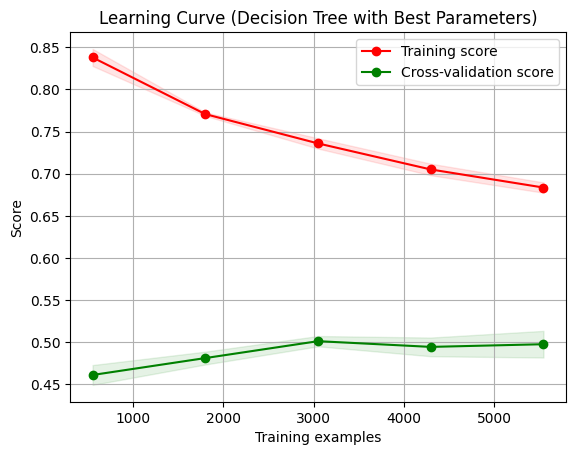

In [10]:
dt_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=19, min_samples_leaf=1, min_samples_split=2)
plot_learning_curve(dt_classifier, "Learning Curve (Decision Tree with Best Parameters)", X_train_tfidf, y_train, cv=5)
plt.show()

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize the Gradient Boosting Classifier with default hyperparameters
gb_classifier = GradientBoostingClassifier()

# Train the Gradient Boosting model
gb_classifier.fit(X_train_tfidf, y_train)

# Predict on the validation data
y_val_pred = gb_classifier.predict(X_val_tfidf)

# Evaluate the model on the validation data for accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy on Validation Data:", val_accuracy)


Accuracy on Validation Data: 0.5722943722943723


In [13]:
gb_classifier = GradientBoostingClassifier() 
plot_learning_curve(gb_classifier, "Learning Curve (Gradient Boosting)", X_train_tfidf, y_train, cv=5)
plt.show()

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Initialize the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier()

# Set up the parameter grid to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

# Best estimator

best_gb = grid_search.best_estimator_

# Predict on the validation data using the best found parameters
y_val_pred = best_gb.predict(X_val_tfidf)

# Evaluate the model on the validation data for accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Best Parameters:", grid_search.best_params_)
print("Accuracy on Validation Data with Best Parameters:", val_accuracy)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
